# Function Definitions
Modified from `scripts/score.py`

In [28]:
import argparse
import json
from pathlib import Path
from typing import Dict, Union

import numpy as np
import numpy.typing
import pandas as pd


TRANSLATION_COLS = ["x", "y", "z"]
QUATERNION_COLS = ["qw", "qx", "qy", "qz"]
POSE_COLS = TRANSLATION_COLS + QUATERNION_COLS
INDEX_COLS = ["chain_id", "i"]
REFERENCE_VALUES = np.array([0, 0, 0, 1, 0, 0, 0], dtype=float)
REFERENCE_SERIES = pd.Series(REFERENCE_VALUES, index=POSE_COLS)
REFERENCE_TOLERANCE = 1e-6

_EPS = np.finfo(float).eps * 4.0

# ESA metric machine precision constants
# ref: https://kelvins.esa.int/pose-estimation-2021/scoring/
TRANS_ERR_THRESHOLD = 0.002173
ROT_ERR_THRESHOLD = 0.169 * np.pi / 180

# Our tweaks to ESA metric—cap the maximum value of the translation error (so that it's not unbounded)
TRANS_MAX_ERROR = 1e3


def transformation_matrix(t: np.ndarray, q: np.ndarray):
    """Generate 4x4 homogeneous transformation matrices, a.k.a. SE(3) matrices, from arrays of 3D point translations
    and unit quaternion representations of rotations. This function is vectorized and operates on arrays of
    transformation parameters.

    Args:
        t (np.ndarray): Nx3 array of translations (tx, ty, tz)
        q (np.ndarray): Nx4 array of unit quaternions (qw, qx, qy, qz)

    Returns:
        np.ndarray: Nx4x4 array of 4x4 transformation matrices
    """
    # Allocate transformation matrices with only translation
    arr_transforms = np.repeat(np.eye(4)[None, :, :], t.shape[0], axis=0)
    arr_transforms[:, :3, 3] = t

    # shift so we have (qx, qy, qz, qw) instead of (qw, qx, qy, qz)
    q = np.roll(q, -1, axis=1)

    nq = np.square(np.linalg.norm(q, axis=1))
    mask = nq >= _EPS  # mask for rotations of magnitude greater than epsilon

    # For transformations with non-zero rotation, calculate rotation matrix
    q = np.sqrt(2.0 / nq)[:, None] * q
    q = q[:, :, None] * q[:, None, :]  # outer product
    arr_transforms[mask, 0, 0] = 1.0 - q[mask, 1, 1] - q[mask, 2, 2]
    arr_transforms[mask, 0, 1] = q[mask, 0, 1] - q[mask, 2, 3]
    arr_transforms[mask, 0, 2] = q[mask, 0, 2] + q[mask, 1, 3]
    arr_transforms[mask, 1, 0] = q[mask, 0, 1] + q[mask, 2, 3]
    arr_transforms[mask, 1, 1] = 1.0 - q[mask, 0, 0] - q[mask, 2, 2]
    arr_transforms[mask, 1, 2] = q[mask, 1, 2] - q[mask, 0, 3]
    arr_transforms[mask, 2, 0] = q[mask, 0, 2] - q[mask, 1, 3]
    arr_transforms[mask, 2, 1] = q[mask, 1, 2] + q[mask, 0, 3]
    arr_transforms[mask, 2, 2] = 1.0 - q[mask, 0, 0] - q[mask, 1, 1]
    return arr_transforms


def ominus(arr_a: np.ndarray, arr_b: np.ndarray) -> np.ndarray:
    """Computes the result of applying the inverse motion composition operator on two pose matrices. This implementation
    is vectorized: arr_a and arr_b should be numpy.ndarray with shape (N, 4, 4) containing N 4x4 transformation
    matrices. The output will also be N 4x4 matrices.

    Args:
        arr_a (np.ndarray): Nx4x4 array of N poses (homogeneous 4x4 matrix)
        arr_b (np.ndarray): Nx4x4 array of N poses (homogeneous 4x4 matrix)

    Returns:
        np.ndarray: Nx4x4 array of N resulting 4x4 relative transformation matrices between a and b
    """
    return np.matmul(np.linalg.inv(arr_b), arr_a)


def compute_distance(arr_transforms: np.ndarray) -> np.ndarray:
    """
    Compute the distance (magnitude) of the translational components of an array of N 4x4 homogeneous matrices.

    Args:
        arr_transforms (np.ndarray): Nx4x4 array of N 4x4 transformation matrices

    Returns:
        np.ndarray: 1D array of length N with distance values
    """
    return np.linalg.norm(arr_transforms[:, :3, 3], axis=1)


def compute_angle(arr_transforms: np.ndarray) -> np.ndarray:
    """
    Compute the rotation angle from the rotational components an array of N 4x4 homogeneous matrices.

    Args:
        arr_transforms (np.ndarray): Nx4x4 array of N 4x4 transformation matrices

    Returns:
        np.ndarray: 1D array of length N with angle values in radians
    """
    trace_r = np.trace(arr_transforms[:, :3, :3], axis1=1, axis2=2)
    raw = (trace_r - 1) / 2
    clipped = np.clip(raw, a_min=-1, a_max=1)
    return np.arccos(clipped)


def normalized_pose_errors(predicted: np.ndarray, actual: np.ndarray) -> Dict[str, numpy.typing.NDArray[float]]:
    """Calculate normalized rotation and translation pose errors for a set predictions against the ground truth.

    This is the absolute pose error. It assumes that poses are described in the reference frame of the initial image of
    the sequence (the "reference pose"). This means the reference pose should be the null pose, i.e., it has a rotation
    component that is the identity and zero translation component.

    The rotation and translation errors are both normalized by the magnitude of the ground truth rotation and
    translation magnitudes, respectively.

    The input array columns should correspond to the position and quaternion coordinates:
    ["x", "y", "z", "qw", "qx", "qy", "qz"]

    Args:
        predicted (np.ndarray): Nx7 array of predicted pose coordinates
        actual (np.ndarray): Nx7 array of ground truth pose coordinates

    Returns:
        dict[str, np.ndarray[float]]: dictionary of arrays of rotation and translation errors
    """
    m, n = actual.shape
    assert n == len(POSE_COLS)
    assert actual.shape == predicted.shape

    # Convert translation vector + rotation quaternions to 4x4 transformation matrices
    predicted_arr_transforms = transformation_matrix(predicted[:, :3], predicted[:, 3:])
    actual_arr_transforms = transformation_matrix(actual[:, :3], actual[:, 3:])

    # First frame is reference frame. We will calculate errors for all subsequent frames
    j_predicted = predicted_arr_transforms[1:, :, :]
    j_actual = actual_arr_transforms[1:, :, :]

    # Absolute pose error of 4x4 transformation matrices
    error44 = ominus(j_predicted, j_actual)

    # Translation error, normalized by magnitude of ground truth translation
    trans_err = compute_distance(error44)
    trans_denom = np.clip(compute_distance(j_actual), a_min=_EPS, a_max=np.inf)  # can't be zero
    corrected_trans_err = trans_err / trans_denom
    corrected_trans_err = np.clip(corrected_trans_err, a_min=0, a_max=TRANS_MAX_ERROR)
    corrected_trans_err = np.where(
        corrected_trans_err >= TRANS_ERR_THRESHOLD, corrected_trans_err, 0.0
    )

    # Rotation error, normalized by magnitude of ground truth rotation
    rot_err = compute_angle(error44)
    rot_denom = np.clip(
        compute_angle(j_actual), a_min=_EPS, a_max=np.inf
    )  # can't be zero
    corrected_rot_err = rot_err / rot_denom
    corrected_rot_err = np.where(
        corrected_rot_err >= ROT_ERR_THRESHOLD, corrected_rot_err, 0.0
    )

    return {
        "translation_errors": trans_err,
        "normalized_translation_errors": corrected_trans_err,
        "rotation_errors": rot_err,
        "normalized_rotation_errors": corrected_rot_err,
    }


def score_chains(predicted_df: pd.DataFrame, actual_df: pd.DataFrame) -> Dict[str, float]:
    """Scores chains of predicted object poses (trajectory of object) against the ground truth. Returns the
    normalized absolute translation and rotation errors over all sequences, and the pose error
    score which is the weighted sum of the two.

    Args:
        predicted_df (np.ndarray): dataframe of predicted pose coordinates
        actual_df (np.ndarray): dataframe of ground truth pose coordinates

    Returns:
        dict[str, float]: dictionary of errors and score
    """
    errors = {}
    chain_ids = actual_df.index.get_level_values(0).unique().values.tolist()
    for chain_id in chain_ids:
        predicted_i = predicted_df.loc[chain_id]
        if not np.allclose(
            predicted_i.loc[0], REFERENCE_VALUES, atol=REFERENCE_TOLERANCE
        ):
            raise ValueError(
                f"Reference row for chain {chain_id} not close enough (|δ| ≤ {REFERENCE_TOLERANCE}) to expected values"
                f"\n    expected: {REFERENCE_VALUES}"
                f"\n    actual: {predicted_i.loc[0].values}"
            )
        actual_i = actual_df.loc[chain_id]
        errors[chain_id] = normalized_pose_errors(predicted_i.values, actual_i.values)

    translation_errors = np.concatenate(
        [
            chain_errors["normalized_translation_errors"]
            for chain_errors in errors.values()
        ]
    )
    rotation_errors = np.concatenate(
        [chain_errors["normalized_rotation_errors"] for chain_errors in errors.values()]
    )

    return {
        "translation_errors": translation_errors,
        "rotation_errors": rotation_errors,
        "overall_errors": translation_errors + rotation_errors,
    }


In [29]:
PREDICTED_PATH = "results.csv"
ACTUAL_PATH = "train_labels_one_chain_only.csv"

try:
    predicted_df = pd.read_csv(PREDICTED_PATH, index_col=INDEX_COLS).loc[:, POSE_COLS]
except ValueError as e:
    raise ValueError("Submitted index columns are missing.") from e
except IndexError as e:
    raise ValueError("Submitted columns do not match expected columns.") from e
try:
    actual_df = pd.read_csv(ACTUAL_PATH, index_col=INDEX_COLS).loc[:, POSE_COLS]
except ValueError as e:
    raise ValueError("Ground truth index columns are missing.") from e
except IndexError as e:
    raise ValueError("Ground truth columns do not match expected.") from e

if not predicted_df.index.equals(actual_df.index):
    raise ValueError("Submitted index does not match expected index")

# Plot a graph of error scores for each chain.
scores = score_chains(predicted_df, actual_df)

# Plotting Results

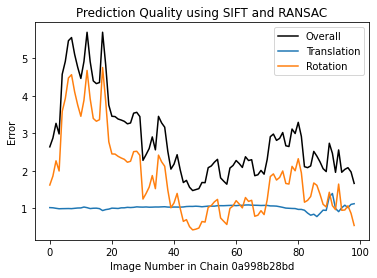

In [30]:
import matplotlib.pyplot as plt

plt.figure(facecolor="white") # Set the background color (outside the plotting region) to white.
X = np.arange(len(scores["overall_errors"]))
plt.plot(X, scores["overall_errors"], label="Overall", color="black")
plt.plot(X, scores["translation_errors"], label="Translation", color="C0") # C0 is blue.
plt.plot(X, scores["rotation_errors"], label="Rotation", color="C1") # C1 is orange.

plt.title("Prediction Quality using SIFT and RANSAC")
plt.xlabel("Image Number in Chain 0a998b28bd")
plt.ylabel("Error")
plt.legend()

# Save the figure to a file.
plt.savefig("prediction_evaluation_SIFT_RANSAC.png", dpi=300)
plt.show()
plt.close()